<a href="https://colab.research.google.com/github/ssudheerrao/test/blob/master/Text_Classification_using_TFIDF_AutoML_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Details of the code and how it works is available in my video - https://youtu.be/EHt_x8r1exU

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df=pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true', compression='zip', sep=',', quotechar='"')

In [ ]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


In [ ]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

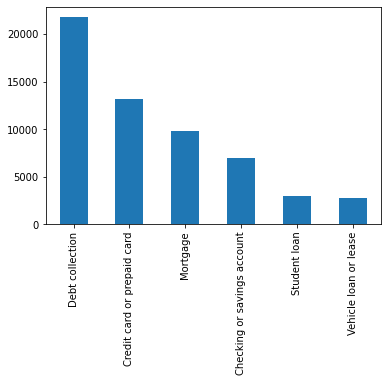

In [ ]:
df['Product'].value_counts().plot(kind='bar')

In [ ]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
YKS Acceptance, Inc.                        1
Peoples Financial Corp.                     1
Credit Information Bureau, Inc.             1
Rossman & Co & PCB                          1
Magnum Association Services                 1
Name: Company, Length: 2197, dtype: int64

In [ ]:
complaints_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})

In [ ]:
pd.set_option('display.max_colwidth', -1)
complaints_df

In [ ]:
target={'Debt collection':0, 'Credit card or prepaid card':1, 'Mortgage':2, 'Checking or savings account':3, 'Student loan':4, 'Vehicle loan or lease':5}

In [ ]:
complaints_df['target']=complaints_df['Product'].map(target)

In [ ]:
complaints_df

In [ ]:
X_train, X_test = train_test_split(complaints_df, test_size=0.2, random_state=111)

In [ ]:
#stemmer = PorterStemmer()
stemmer = nltk.stem.SnowballStemmer('english')

In [ ]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def tokenize(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   tokens = map(str.lower, tokens)
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

In [ ]:
##complaints_df['complaints_tok']=complaints_df['complaints'].apply(lambda x: tokenize(x))

In [ ]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.complaints) 

In [ ]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05982223, 0.        , ..., 0.        , 0.        ,
        0.04798975],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09582682],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
vectorizer_tf.get_feature_names()

In [ ]:
test_vectors = vectorizer_tf.transform(X_test.complaints)

In [ ]:
X_train.shape
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45962 entries, 37801 to 12116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   complaints  45962 non-null  object
 1   Product     45962 non-null  object
 2   Company     45962 non-null  object
 3   target      45962 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [ ]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)], axis=1)
train_df

In [ ]:
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)], axis=1)
test_df

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})

In [ ]:
xgb_clf.fit(train_vectors, X_train['target'])

[13:51:11] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [ ]:
predictions = xgb_clf.predict(test_vectors)

In [ ]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3941  156   63   37   46   52]
 [ 282 2177   13   99    1   11]
 [  97   37 1823   24    8   26]
 [  89  131   21 1213    0    7]
 [  77   23   29    2  461   19]
 [ 107   53   35    9    4  318]]


In [ ]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4295
           1       0.84      0.84      0.84      2583
           2       0.92      0.90      0.91      2015
           3       0.88      0.83      0.85      1461
           4       0.89      0.75      0.82       611
           5       0.73      0.60      0.66       526

    accuracy                           0.86     11491
   macro avg       0.85      0.81      0.83     11491
weighted avg       0.86      0.86      0.86     11491



In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(X_train['target']),
                                             X_train['target']))

In [ ]:
class_weights

[0.43830939711239536,
 0.7219918316054037,
 0.9841127098321343,
 1.382232647660291,
 3.275046316089497,
 3.466214177978884]

In [ ]:
weights = np.ones(X_train.shape[0], dtype = 'float')

In [ ]:
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
for i, val in enumerate(X_train['target']):
    weights[i] = class_weights[val]

In [ ]:
weights

array([1.38223265, 0.4383094 , 0.4383094 , ..., 0.72199183, 0.72199183,
       0.98411271])

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})

In [ ]:
xgb_clf.fit(train_vectors, X_train['target'], sample_weight=weights)

[13:55:03] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [ ]:
#print("Accuracy score (test): {0:.3f}".format(xgb_clf.score(test_vectors, X_test['target'])))

In [ ]:
predictions = xgb_clf.predict(test_vectors)

In [ ]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3650  182   79  109   92  183]
 [ 167 2109   19  176    2  110]
 [  41   19 1782   32   52   89]
 [  33   93   16 1291    5   23]
 [  25    6    4    2  517   57]
 [  48   20   10   12   20  416]]


In [ ]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      4295
           1       0.87      0.82      0.84      2583
           2       0.93      0.88      0.91      2015
           3       0.80      0.88      0.84      1461
           4       0.75      0.85      0.80       611
           5       0.47      0.79      0.59       526

    accuracy                           0.85     11491
   macro avg       0.79      0.85      0.81     11491
weighted avg       0.87      0.85      0.85     11491

